# Import libraries

In [39]:
import numpy as np
import pandas as pd
import os

from decorator import append

# Read data

In [40]:
DATASET_PATH = '../../data/processed/HAR'
DATASET_CSV_PATH = f'{DATASET_PATH}/UCF'

In [41]:
LABEL = {
    'Jump': 0,
    'Kick': 1,
    'Punch': 2,
    'Left': 3,
    'Right': 4,
    'Stand': 5
}

In [42]:
X = []
y = []

# Read all files in the dataset
for label in LABEL:
    for file in os.listdir(f'{DATASET_CSV_PATH}/Train/{label}'):
        df = pd.read_csv(f'{DATASET_CSV_PATH}/Train/{label}/{file}', sep=',')
        X.append(df)
        y.append(LABEL[label])

In [43]:
# Drop first and second columns
for i, element in enumerate(X):
    X[i] = element.drop(element.columns[[0, 1]], axis=1)

In [44]:
for i, element in enumerate(X):
    for column in element.columns:
        X[i][column] = X[i][column].apply(lambda x: np.array(x[1:-1].split(',')).astype(np.float32))

## Convert All Sequences to the Same Length

In [45]:
# Get the maximum length of all sequences
all_dim = []
for i, element in enumerate(X):
    all_dim.append(element.shape[0])
    # print(f"Element {i} shape: {np.shape(element)}, label: {y[i]}")

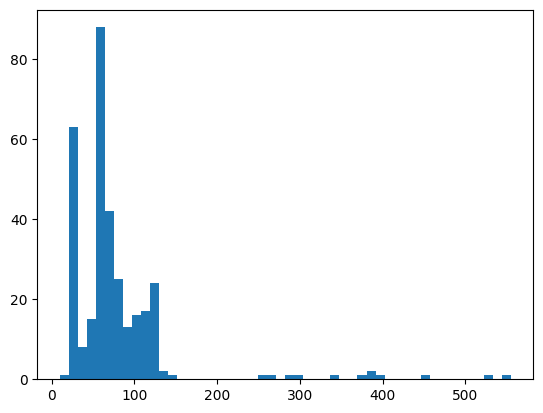

In [46]:
# Visualize the distribution of the lengths of all sequences
import matplotlib.pyplot as plt
plt.hist(all_dim, bins=50)
plt.show()

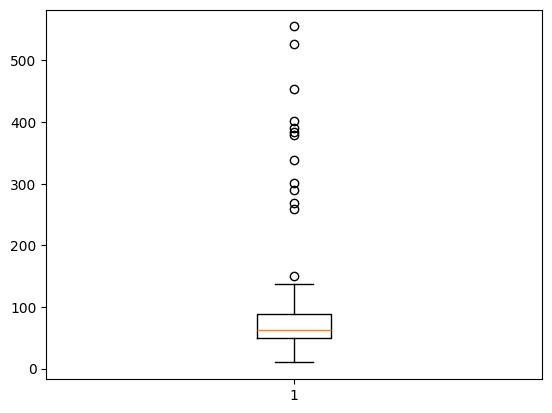

In [47]:
# Visualize the boxplot of the lengths of all sequences
plt.boxplot(all_dim)
plt.show()

### Handle the Outliers and make the lengths of all sequences the same
Handle different lengths of sequences
    Set the maximum length = 1.5 * IQR + Q3
    
    * Case 1: If e_dim < Max_dim, then increase the length of the sequence by duplicating each row until the length of the sequence is equal to Max_dim
    * Case 2: If e_dim > Max_dim, then truncate randomly the sequence until the length of the sequence is equal to Max_dim
    * Case 3: If e_dim = Max_dim, then keep the sequence as it is

In [48]:
# Convert all sequences to the same length
Q1 = np.percentile(all_dim, 25)
Q3 = np.percentile(all_dim, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")

Q1: 50.5, Q3: 89.0, IQR: 38.5, Lower bound: -7.25, Upper bound: 146.75


In [49]:
# Drop outliers
for i, element in enumerate(X):
    if element.shape[0] < lower_bound or element.shape[0] + 1> upper_bound:
        X.pop(i)
        y.pop(i)

In [50]:
Max_dim = 35 

In [51]:
X[0]['pose_0'][0].shape

(3,)

In [52]:
test = np.array(X[0])
test.shape

(61, 33)

In [53]:
X_train_temp = []
Y_train_temp = []

def pad_length(ele, max_dim, metric_temp:list=None) -> np.array:
    if metric_temp is None:
        metric_temp = []
    if ele.shape[0] == max_dim:
        return pd.DataFrame(ele)

    step = max(1, ele.shape[0] // (max_dim - ele.shape[0]))

    for j in range(0, ele.shape[0]):
        metric_temp.append(ele.iloc[j])
        if len(metric_temp) == max_dim:
            break
        if j % step == 0:
            metric_temp.append(ele.iloc[j])
        if len(metric_temp) == max_dim:
            break
    return pad_length(pd.DataFrame(metric_temp), max_dim)

def truncate_length(ele, max_dim, start=0) -> np.array:
    if ele.shape[0] == max_dim:
        return pd.DataFrame(ele)

    metrics_temp:list = []
    step = max(2, ele.shape[0] // (ele.shape[0] - max_dim))
    j = start
    while len(metrics_temp) != max_dim:
        metrics_temp.append(ele.iloc[j])
        j = (j + step) % ele.shape[0]
    return pd.DataFrame(metrics_temp)

def pad_and_truncate(ele, max_dim: int=35) -> np.array:
    list_elements:list = []
    current_length = ele.shape[0]

    if current_length == max_dim:
        return [ele]

    dev = max(int(round(current_length / max_dim)), 1)
    if dev * max_dim > current_length:
        new_element = pad_length(ele, max_dim * dev)

        if new_element.shape[0] > max_dim:
            for step in range(dev):
                list_elements.append(truncate_length(new_element, max_dim, step))
        else:
            list_elements.append(new_element)
    else:
        for step in range(dev):
            list_elements.append(truncate_length(ele, max_dim, step))
    return list_elements
# Pad all sequences to the same length
for i, element in enumerate(X):
    print(f"Before padding, element {i} shape: {np.shape(element)}")
    padded_element = pad_and_truncate(element, Max_dim)
    print(f"After padding, element {i} shape: {np.shape(padded_element)}")
    X_train_temp = X_train_temp + padded_element
    Y_train_temp = Y_train_temp + [y[i]] * len(padded_element)
    print('y[i]: ', y[i])
    print(f"After padding X_train_temp, element {i} shape: {np.shape(X_train_temp)}")
    print(f"After padding Y_train_temp, element {i} shape: {np.shape(Y_train_temp)}")
    print('-----------------------------------')
# test = X[15]
# padded_element = pad_and_truncate(test, Max_dim)
# np.array(padded_element).shape

Before padding, element 0 shape: (61, 33)
After padding, element 0 shape: (2, 35, 33)
y[i]:  0
After padding X_train_temp, element 0 shape: (2, 35, 33)
After padding Y_train_temp, element 0 shape: (2,)
-----------------------------------
Before padding, element 1 shape: (61, 33)
After padding, element 1 shape: (2, 35, 33)
y[i]:  0
After padding X_train_temp, element 1 shape: (4, 35, 33)
After padding Y_train_temp, element 1 shape: (4,)
-----------------------------------
Before padding, element 2 shape: (64, 33)
After padding, element 2 shape: (2, 35, 33)
y[i]:  0
After padding X_train_temp, element 2 shape: (6, 35, 33)
After padding Y_train_temp, element 2 shape: (6,)
-----------------------------------
Before padding, element 3 shape: (54, 33)
After padding, element 3 shape: (2, 35, 33)
y[i]:  0
After padding X_train_temp, element 3 shape: (8, 35, 33)
After padding Y_train_temp, element 3 shape: (8,)
-----------------------------------
Before padding, element 4 shape: (66, 33)
After 

In [54]:
X_train_ = np.array(X_train_temp)

In [20]:
X_train_temp

695

In [55]:
X_train = np.full((X_train_.shape[0], X_train_.shape[1], X_train_.shape[2], 3), np.nan, dtype=np.float32)

for i, element in enumerate(X_train_):
    for j, row in enumerate(element):
        for k, value in enumerate(row):
            # Check if the value is np.array([nan, nan, nan])
            if np.isnan(value).all():
                X_train_[i][j][k] = np.array([np.nan, np.nan, np.nan], dtype=np.float32)
            else:
                X_train_[i][j][k] = value
                
            X_train[i][j][k] = X_train_[i][j][k][:3]

In [168]:
X_train.shape

(666, 35, 33, 3)

## Handle Fill NaN Values

### Step 1: Compute the variance of each metric for each sequence.

### Step 2: Fill NaN
   * **Case 1**: If `element[i]` doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
   * **Case 2**: If `element[i]` doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
   * **Case 3**: If `element[i]` has values both before and after, then use the nearest previous and posterior elements:
     - For \( k < i < l \):

$$
\text{element}[i] = \text{element}[k] + (\text{element}[l] - \text{element}[k]) \times \frac{i - k}{l - k}
$$


### Step 1: Compute the variance of each metric for each sequence.

In [169]:
X_train.shape

(666, 35, 33, 3)

In [170]:
cnt = 0

In [171]:
np.nanvar(X_train[0][:, 0], axis=0)

array([0.00015411, 0.01530908, 0.03416489], dtype=float32)

In [172]:
variance_metric = np.empty((X_train.shape[0], X_train.shape[2], 3), dtype=np.float32)
variance_metric.shape

(666, 33, 3)

In [173]:
X_train[0][:, 0].shape

(35, 3)

In [174]:
np.nanvar(X_train[1][:, 0], axis=0)

array([0.0001407 , 0.01512058, 0.03050509], dtype=float32)

In [22]:
cls_nan = dict()

for i, element in enumerate(X_train):
    sub_variance_metric = np.empty((element.shape[1], 3), dtype=np.float32)
    
    for j in range(element.shape[1]):
        variance = np.array([np.nan, np.nan, np.nan], dtype=np.float32)
        
        # If there are more than 1 non-NaN values, calculate variance
        if np.count_nonzero(~np.isnan(element[:, j])) > 1:
            variance = np.nanvar(element[:, j], axis=0)
            print(variance)
        else:
            if i not in cls_nan:
                cls_nan[i] = []
            cls_nan[i].append(j)
        # convert to list
        sub_variance_metric[j] = variance
    # print(sub_variance_metric)
    variance_metric[i] = sub_variance_metric

NameError: name 'X_train' is not defined

In [176]:
variance_metric = np.array([variance_metric], dtype=np.float32)

In [177]:
variance_metric = variance_metric.reshape(variance_metric.shape[1], variance_metric.shape[2], variance_metric.shape[3])

In [178]:
variance_metric.shape

(666, 33, 3)

In [179]:
# convert to cls_nan to pandas dataframe
cls_nan.keys()

dict_keys([])

In [128]:
LABEL

{'Jump': 0, 'Kick': 1, 'Punch': 2, 'Left': 3, 'Right': 4, 'Stand': 5}

### Step 2: Fill NaN
   * **Case 1**: If `element[i]` doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
   * **Case 2**: If `element[i]` doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
   * **Case 3**: If `element[i]` has values both before and after, then use the nearest previous and posterior elements:
     - For \( k < i < l \):

$$
\text{element}[i] = \text{element}[k] + (\text{element}[l] - \text{element}[k]) \times \frac{i - k}{l - k}
$$


In [129]:
X_train.shape

(327, 147, 33, 3)

In [130]:
variance_metric.shape

(327, 33, 3)

In [180]:
# Function to fill NaN values based on the described cases
def fill_nan(element, variance_metric):
    old_value = None
    k = 0
    
    for i in range(element.shape[0]):
        if np.isnan(element[i]).all():
            # Case 1: If element[i] doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
            if old_value is None:
                for l in range(i + 1, element.shape[0]):
                    if not np.isnan(element[l]).all():
                        element[i] = element[l] + abs(i - l) * variance_metric
                        break
            else:
                # Case 2: If element[i] doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
                flat = False
                for l in range(i + 1, element.shape[0]):
                    if not np.isnan(element[l]).all():
                        if l != k:
                            element[i] = old_value + (element[l] - old_value) / ((i - k) / (l - k))
                            flat = True
                            break
                if not flat:
                    # Case 3: If element[i] has values both before and after, then use the nearest previous and posterior elements
                    element[i] = old_value - abs(i - k) * variance_metric
        old_value = element[i]
    return element

In [181]:
X_train_new = np.empty(X_train.shape, dtype=np.float32)
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[2]):
        # print("Shape of element: ", X_train[i][: , j].shape)
        # print("Shape of variance: ", variance_metric[i][j].shape)
        X_train_new[i][: , j] = fill_nan(X_train[i][: , j], variance_metric[i][j])

In [187]:
# Save the processed data
np.save('X_train.npy', X_train_new)
np.save('y_train.npy', Y_train_temp)

In [139]:
import numpy as np
# Load the processed data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

In [140]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[2]):
        if np.isnan(X_train[i][:, j]).sum() > 0:
            print(f"Element {i}, Metric {j}, NaN: {np.isnan(X_train[i][:, j]).sum()}")

## LSTM model LSTM model

In [141]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [142]:
import tensorflow as tf 
# check version
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional

2.16.1


In [143]:
print("GPUs available:", len(tf.config.list_physical_devices('GPU')))

GPUs available: 1


In [144]:
!nvidia-smi

Mon Oct  7 15:24:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti     On  | 00000000:01:00.0  On |                  N/A |
| 30%   42C    P8              18W / 200W |   7964MiB /  8192MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [145]:
X_train.shape

(327, 147, 33, 3)

In [146]:
# Reshape the data
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2] * X_train.shape[3])

In [147]:
# Define LSTM models
model = keras.models.Sequential() 
model.add(Bidirectional(LSTM(1024, return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.5))  # Dropout rate reduced
model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
model.add(Dense(len(LABEL), activation='softmax'))
# Compile the models
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

2024-10-07 15:24:13.039203: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-07 15:24:13.039328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-07 15:24:13.039378: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

InternalError: cudaSetDevice() on GPU:0 failed. Status: out of memory

In [20]:
y_train.shape

(308,)

In [21]:
# divide validation set and train set
from sklearn.model_selection import train_test_split
X_train_reshaped, X_val, y_train, y_val = train_test_split(X_train_reshaped, y_train, test_size=0.2, random_state=42)

In [24]:
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=256, validation_data=(X_val, y_val))

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.3049 - loss: 1.6485 - val_accuracy: 0.3226 - val_loss: 1.5720
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3415 - loss: 1.6556 - val_accuracy: 0.3226 - val_loss: 1.5653
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3130 - loss: 1.6626 - val_accuracy: 0.3226 - val_loss: 1.5592
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3496 - loss: 1.6068 - val_accuracy: 0.3226 - val_loss: 1.5547
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3780 - loss: 1.5933 - val_accuracy: 0.3226 - val_loss: 1.5520
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3780 - loss: 1.5518 - val_accuracy: 0.3226 - val_loss: 1.5483
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3415 - loss: 1.6157 - val_accuracy: 0.3226 - val_loss: 1.5454
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3374 - loss: 1.5837 - val_accuracy: 0.3226 - val_loss: 1.5415
Epoch 9/

In [ ]:
# Save the models
model.save('models.h5')

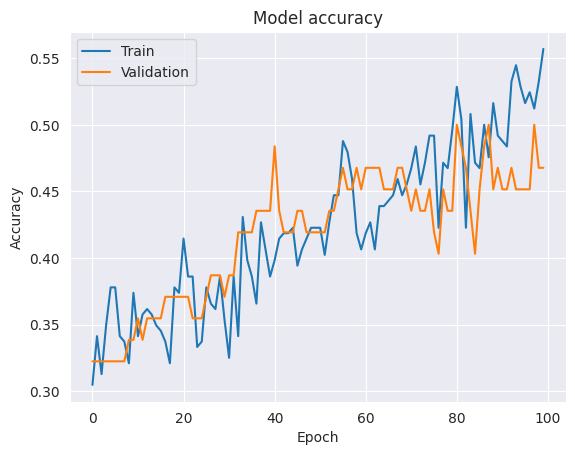

In [25]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
# Metrics
model.evaluate(X_train_reshaped, y_train)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.6398 - loss: 1.0917


[1.1036224365234375, 0.6260162591934204]

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step


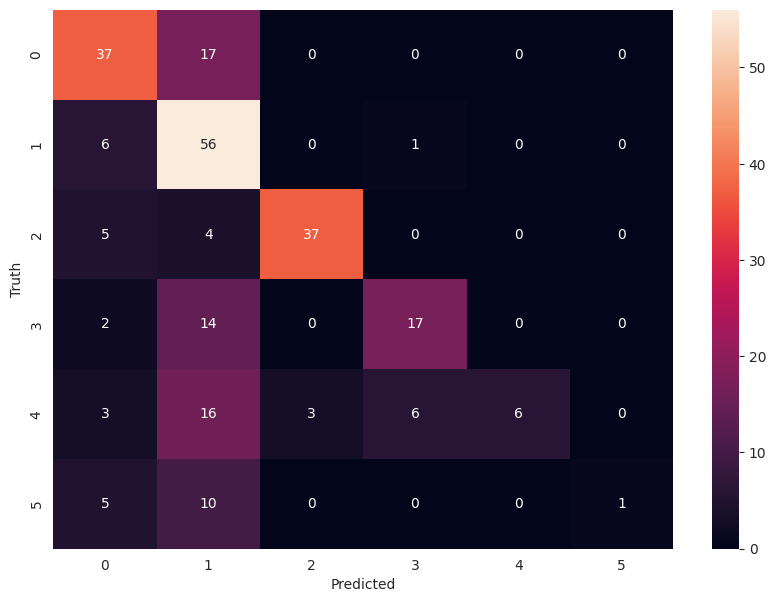

In [28]:
# Show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_train_reshaped)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [63]:
LABEL

{'Jump': 0, 'Kick': 1, 'Punch': 2, 'Left': 3, 'Right': 4, 'Stand': 5}